In [113]:
import numpy as np
import matplotlib.pyplot as plt

def read_currents_file(filepath):
    # Read the file content
    with open(filepath, 'r') as file:
        # Read the first line to get current names
        header_line = file.readline().strip()
        
        # Split the header first by semicolons, then by commas
        current_groups = header_line.split(';')
        current_names = []
        for group in current_groups:
            currents = [name.strip() for name in group.split(',')]
            current_names.extend(currents)
            
        # Initialize dictionary with empty lists for each current
        data_dict = {name: [] for name in current_names}
        
        # Read the rest of the lines
        for line in file:
            if not line.strip():  # Skip empty lines
                continue
            
            # Split values by semicolon first, then comma
            value_groups = line.strip().split(';')
            values = []
            for group in value_groups:
                group_values = [float(val.strip()) for val in group.split(',') if val.strip()]
                values.extend(group_values)
            
            # Add each value to corresponding current's list
            for name, value in zip(current_names, values):
                data_dict[name].append(value)
    
    # Convert lists to numpy arrays for easier manipulation
    for name in data_dict:
        data_dict[name] = np.array(data_dict[name])
    
    return data_dict

# Example usage:
filepath = 'currents_ovvr_APD_step_3.csv'
currents_data = read_currents_file(filepath)

# Print information about the data
print("Available currents:")
for current_name, values in currents_data.items():
    print(f"{current_name}: {len(values)} time points, range: [{min(values):.3f}, {max(values):.3f}]")

Available currents:
voltage: 6000 time points, range: [-87.828, 43.353]
INa: 6000 time points, range: [-10.818, -0.001]
Ito: 6000 time points, range: [-0.000, 0.824]
ICaL: 6000 time points, range: [-1.242, -0.000]
IKr: 6000 time points, range: [-0.001, 0.860]
IKs: 6000 time points, range: [-0.001, 0.106]
IK1: 6000 time points, range: [-0.028, 0.826]
INaCa: 6000 time points, range: [-0.141, 0.050]
INaK: 6000 time points, range: [0.092, 0.199]
INab: 6000 time points, range: [-0.017, -0.001]
ICab: 6000 time points, range: [-0.019, -0.000]
IKb: 6000 time points, range: [-0.000, 0.332]
IpCa: 6000 time points, range: [0.000, 0.000]
INalate: 6000 time points, range: [-0.161, -0.000]
NA: 18000 time points, range: [0.000, 0.000]


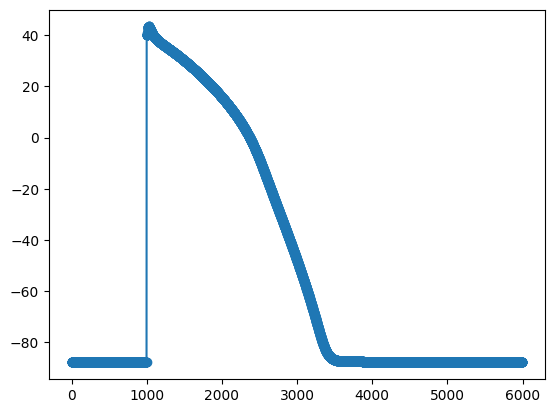

In [130]:
# get the time step range where voltage is bigger than -
mask =  -100< currents_data['voltage']
plt.plot(currents_data['voltage'][mask],'-o')

In [131]:
matrix = np.zeros((len(currents_data['voltage'][mask]),len(currents_data)-2))  # Exclude voltage and NA from currents

In [132]:
# assign currents to matrix columns
for i, (current_name, values) in enumerate(currents_data.items()):
    if current_name not in ['voltage', 'NA']:
        matrix[:, i - (1 if 'voltage' in currents_data else 0) - (1 if 'NA' in currents_data else 0)] = values[mask]

In [133]:
U, S, V = np.linalg.svd(matrix)

In [134]:
S

array([3.85678333e+01, 2.57580765e+01, 1.81231613e+01, 1.14518428e+01,
       6.43643193e+00, 5.09136802e+00, 1.51946720e+00, 1.13994153e+00,
       6.94165412e-01, 6.09068658e-01, 1.93451217e-02, 2.26008597e-04,
       1.09746826e-04])

In [135]:
V

array([[ 1.45228950e-01, -5.07104123e-01,  6.61892223e-01,
         6.86693587e-02,  5.55609839e-02, -8.24187817e-02,
         1.96484626e-01, -6.60720940e-03, -5.24269092e-03,
         1.81317126e-01,  1.91575589e-04, -1.51558157e-01,
        -4.17772814e-01],
       [-5.40485152e-02, -7.58998300e-02,  4.42309096e-01,
         4.54997710e-02,  8.38415865e-02, -6.93770880e-02,
         8.31743803e-02, -5.74856722e-03, -5.35589868e-03,
         1.97011360e-02,  1.12462434e-04, -6.44648578e-02,
         8.77635597e-01],
       [-2.63913857e-01,  7.01907564e-01,  4.76644924e-01,
         2.84506207e-02,  2.79197746e-01, -1.52001432e-01,
        -1.21641060e-02, -1.26475842e-02, -1.39793254e-02,
        -2.35869507e-01,  4.34017844e-05,  1.18276240e-02,
        -2.28783615e-01],
       [ 1.51022948e-01, -1.40419260e-01, -2.49341136e-01,
        -7.40960175e-02,  9.15257098e-01, -1.31160123e-01,
         1.45876607e-01, -2.97220430e-02, -3.45830572e-02,
         4.92981096e-02,  1.92025300e

In [136]:
def projection_S(v):
    ps = [0] * len(S)
    for i in range(2,len(V)):
        ps += np.inner(v,V[i]) / np.inner(V[i],V[i]) * V[i]
    return ps
identifiability = {}
for i, (current_name, values) in enumerate(currents_data.items()):
    if current_name in ['voltage', 'NA']:
        continue
    v_I = [0]*len(S)
    v_I[i-2] = 1
    k = np.linalg.norm(v_I-projection_S(v_I))
    identifiability[current_name] = k

In [137]:
identifiability
# now we sort identifiability by its value
sorted_identifiability = dict(sorted(identifiability.items(), key=lambda item: item[1], reverse=True))
sorted_identifiability

{'INa': np.float64(0.971997101769259),
 'IKr': np.float64(0.796077038960715),
 'ICaL': np.float64(0.5127527437148443),
 'INaK': np.float64(0.2133639753479803),
 'IKb': np.float64(0.18238430551602688),
 'INalate': np.float64(0.16469849056789104),
 'Ito': np.float64(0.15496028469442885),
 'INaCa': np.float64(0.10773131350640579),
 'IK1': np.float64(0.10058048797941219),
 'IKs': np.float64(0.08237542097548013),
 'INab': np.float64(0.008757924479363303),
 'ICab': np.float64(0.007494762087748894),
 'IpCa': np.float64(0.00022214635980865834)}

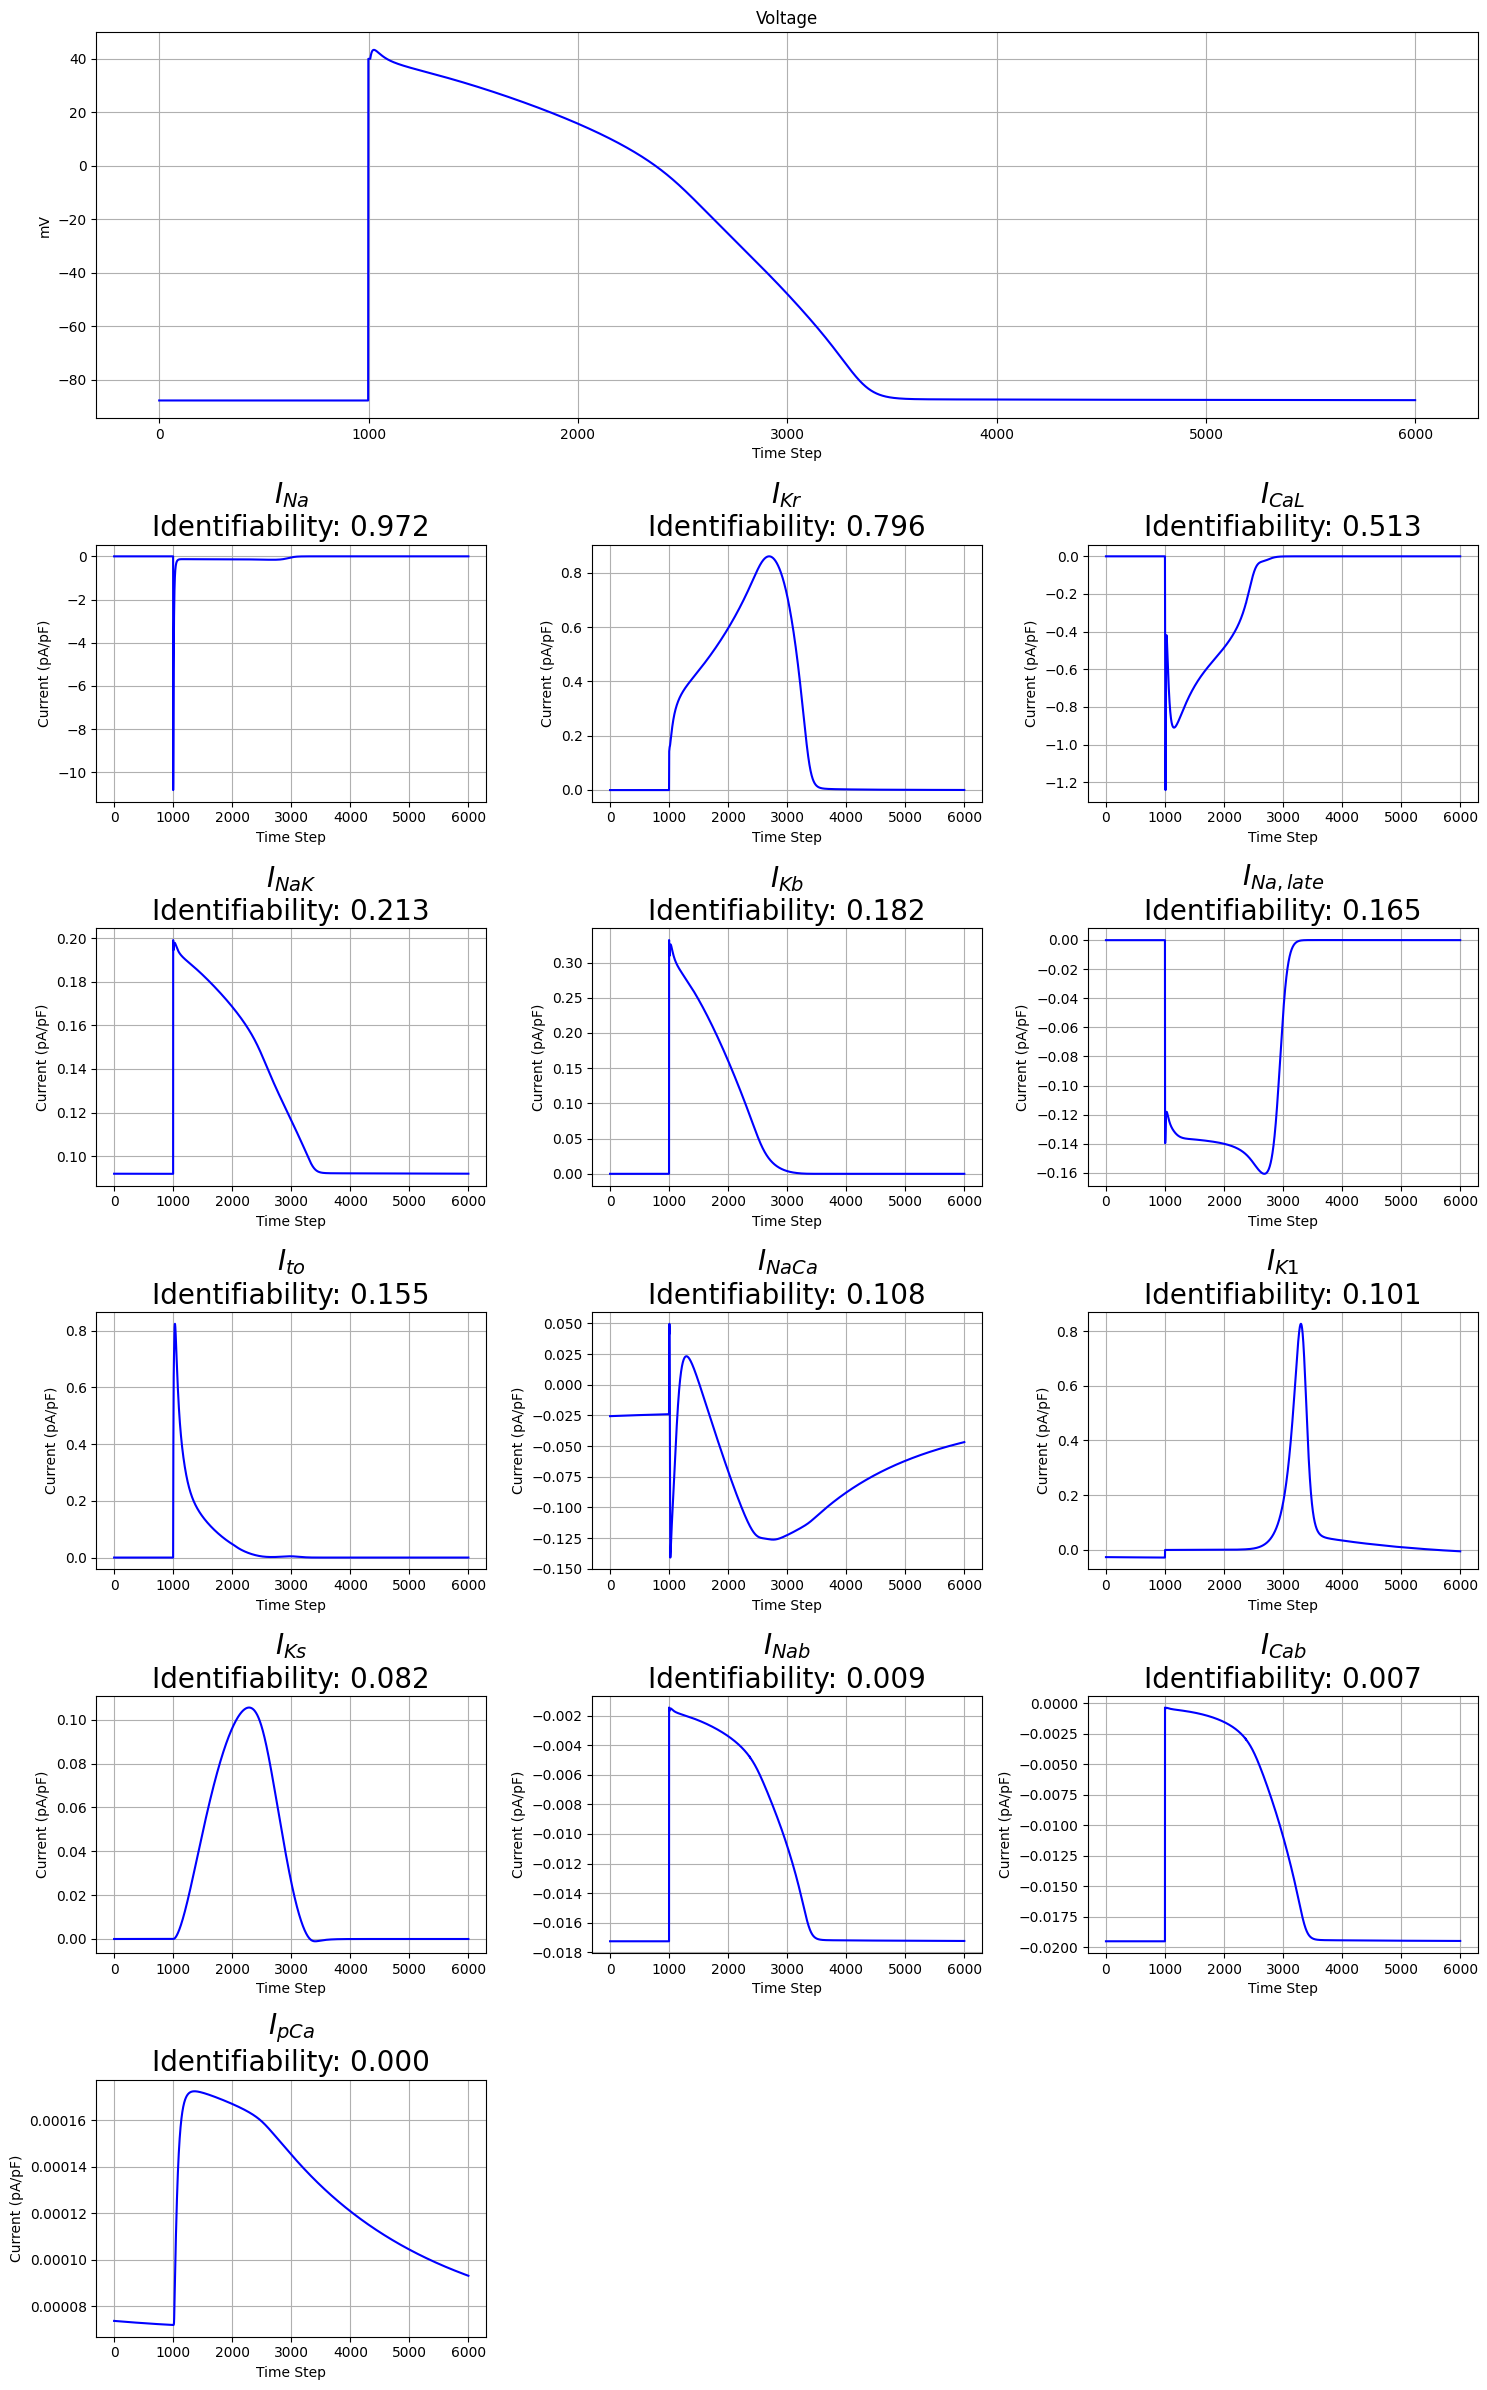

In [138]:
def plot_sorted_currents_with_identifiability(currents_data, sorted_identifiability):
    # Get currents in sorted order (already sorted by identifiability)
    currents_to_plot = list(sorted_identifiability.keys())
    n_currents = len(currents_to_plot)
    
    # Create figure with special grid
    fig = plt.figure(figsize=(15, 4*(n_currents//3 + 2)))  # +2 for voltage row
    
    # Create grid with different row heights
    gs = plt.GridSpec(n_currents//3 + 2, 3, height_ratios=[1.5] + [1]*(n_currents//3 + 1))
    
    # Plot voltage across entire first row
    ax_voltage = fig.add_subplot(gs[0, :])
    ax_voltage.plot(currents_data['voltage'][mask], 'b-')
    ax_voltage.set_title('Voltage')
    ax_voltage.set_ylabel('mV')
    ax_voltage.set_xlabel('Time Step')
    ax_voltage.grid(True)
    
    # Plot currents in remaining grid
    for idx, current_name in enumerate(currents_to_plot):
        row = (idx // 3) + 1  # +1 because voltage took first row
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        
        # Plot the current
        ax.plot(currents_data[current_name][mask], 'b-')
        
        # Set title with identifiability value
        identifiability_value = sorted_identifiability[current_name]
        def format_current_name(name):
            # Dictionary for special current name formatting
            current_formats = {
                'INa': 'I_{Na}',
                'ICaL': 'I_{CaL}',
                'Ito': 'I_{to}',
                'IKr': 'I_{Kr}',
                'IKs': 'I_{Ks}',
                'IK1': 'I_{K1}',
                'INaCa': 'I_{NaCa}',
                'INaK': 'I_{NaK}',
                'INab': 'I_{Nab}',
                'ICab': 'I_{Cab}',
                'IKb': 'I_{Kb}',
                'IpCa': 'I_{pCa}',
                'INalate': 'I_{Na,late}'
            }
            return current_formats.get(name, name)  # Return formatted name or original if not in dictionary

        # Then modify the title setting line to:
        ax.set_title(f'${format_current_name(current_name)}$\nIdentifiability: {identifiability_value:.3f}',fontsize=20)        
        ax.set_ylabel('Current (pA/pF)')
        ax.set_xlabel('Time Step')
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('currents_sorted_by_identifiability.png', dpi=300)
    plt.show()

# Usage:
plot_sorted_currents_with_identifiability(currents_data, sorted_identifiability)
